In [1]:
import torchgeo
import terratorch
import yaml
import pdb

/dccstor/cimf/paolo/miniconda3/envs/terratorch/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/dccstor/cimf/paolo/miniconda3/envs/terratorch/lib/python3.10/site-packages/kornia/feature/lightglue.py:44: FutureWarning: `torch.cuda.amp.custom_fwd(args...)` is deprecated. Please use `torch.amp.custom_fwd(args..., device_type='cuda')` instead.
  @torch.cuda.amp.custom_fwd(cast_inputs=torch.float32)


wxc_downscaling not installed


In [2]:
torchgeo.__version__

'0.7.0.dev0'

In [3]:
import torch
# from torchgeo.trainers import ObjectDetectionTask
# from terratorch.tasks import ObjectDetectionTask
from torchgeo.datasets import VHR10
from torch.utils.data import DataLoader
import lightning.pytorch as pl
import matplotlib.pyplot as plt

In [4]:
import torch
import albumentations as A
from collections.abc import Callable
from functools import partial
from albumentations.pytorch import transforms as T
import numpy as np

class Normalize(Callable):
    def __init__(self, means, stds, max_pixel_value=None):
        super().__init__()
        self.means = means
        self.stds = stds

    def __call__(self,  **kwargs):
        # min_value = self.means - 2 * self.stds
        # max_value = self.means + 2 * self.stds
        # img = (batch["image"] - min_value) / (max_value - min_value)
        # img = torch.clip(img, 0, 1)
        # batch["image"] = img
        # return batch
        pdb.set_trace()
        batch = kwargs
        batch['image']=torch.stack(tuple(batch["image"]))
        image = batch["image"]/max_pixel_value if max_pixel_value is not None else batch["image"]
        if len(image.shape) == 5:
            means = torch.tensor(self.means, device=image.device).view(1, -1, 1, 1, 1)
            stds = torch.tensor(self.stds, device=image.device).view(1, -1, 1, 1, 1)
        elif len(image.shape) == 4:
            means = torch.tensor(self.means, device=image.device).view(1, -1, 1, 1)
            stds = torch.tensor(self.stds, device=image.device).view(1, -1, 1, 1)
        else:
            msg = f"Expected batch to have 5 or 4 dimensions, but got {len(image.shape)}"
            raise Exception(msg)
        batch["image"] = (image - means) / stds
        # pdb.set_trace()
        return batch


def get_transform(train, image_size=1472):
    transforms = []
    transforms.append(A.PadIfNeeded(min_height=image_size, min_width=image_size, value=0, border_mode=0))
    if train:
        transforms.append(A.RandomCrop(width=image_size, height=image_size))
        transforms.append(A.HorizontalFlip(p=0.5))
    else:
        transforms.append(A.CenterCrop(width=image_size, height=image_size))
    transforms.append(A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225), max_pixel_value=255))
    transforms.append(A.ToFloat())
    transforms.append(T.ToTensorV2())
    # return A.Compose(transforms, additional_targets={'boxes': 'bboxes', 'masks': 'mask'})
    return A.Compose(transforms, bbox_params=A.BboxParams(format="pascal_voc", label_fields=['labels']), is_check_shapes=False)

def apply_transforms(sample, transforms):


    # pdb.set_trace()
    sample['image']=torch.stack(tuple(sample["image"]))
    sample['image'] = sample['image'].permute(1, 2, 0) if len(sample['image'].shape) == 3 else sample['image'].permute(0, 2, 3, 1)
    sample['image'] = np.array(sample['image'].cpu())
    sample["masks"] = [np.array(torch.stack(tuple(x)).cpu()) for x in sample["masks"]]
    # sample["masks"] = np.array(sample["masks"].cpu())
    sample["boxes"] = np.array(sample["boxes"].cpu())
    sample["labels"] = np.array(sample["labels"].cpu())
    # sample["boxes"] = [torch.stack(tuple(x)) for x in sample["masks"]]
    # sample["labels"] =  
    transformed = transforms(image=sample['image'],
                             masks=sample["masks"], 
                             # bboxes=np.array(torch.stack(tuple(sample["boxes"]), dim=0).cpu()), 
                             bboxes=sample["boxes"],
                             labels=sample["labels"])
    
    transformed['boxes'] = torch.tensor(transformed['bboxes'])
    transformed['labels'] = torch.tensor(transformed['labels'], dtype=torch.int64)
    del transformed['bboxes']
    # print("Done transform")
    return transformed

transforms = get_transform(True, image_size=896)

In [5]:
def preprocess(sample):
    sample["image"] = sample["image"].float() / 255.0
    return sample
# ds = VHR10(root='data/VHR10/', split='positive', transforms=preprocess, download=True)
ds = VHR10(root='data/VHR10/', split='positive', transforms=partial(apply_transforms, transforms=transforms), download=True)

Files already downloaded and verified
loading annotations into memory...
Done (t=0.03s)
creating index...
index created!


In [6]:
len(ds)

650

In [7]:
ds[0]

{'image': tensor([[[-2.1179, -2.1179, -2.1179,  ..., -2.1179, -2.1179, -2.1179],
          [-2.1179, -2.1179, -2.1179,  ..., -2.1179, -2.1179, -2.1179],
          [-2.1179, -2.1179, -2.1179,  ..., -2.1179, -2.1179, -2.1179],
          ...,
          [-2.1179, -2.1179, -2.1179,  ..., -2.1179, -2.1179, -2.1179],
          [-2.1179, -2.1179, -2.1179,  ..., -2.1179, -2.1179, -2.1179],
          [-2.1179, -2.1179, -2.1179,  ..., -2.1179, -2.1179, -2.1179]],
 
         [[-2.0357, -2.0357, -2.0357,  ..., -2.0357, -2.0357, -2.0357],
          [-2.0357, -2.0357, -2.0357,  ..., -2.0357, -2.0357, -2.0357],
          [-2.0357, -2.0357, -2.0357,  ..., -2.0357, -2.0357, -2.0357],
          ...,
          [-2.0357, -2.0357, -2.0357,  ..., -2.0357, -2.0357, -2.0357],
          [-2.0357, -2.0357, -2.0357,  ..., -2.0357, -2.0357, -2.0357],
          [-2.0357, -2.0357, -2.0357,  ..., -2.0357, -2.0357, -2.0357]],
 
         [[-1.8044, -1.8044, -1.8044,  ..., -1.8044, -1.8044, -1.8044],
          [-1.8044,

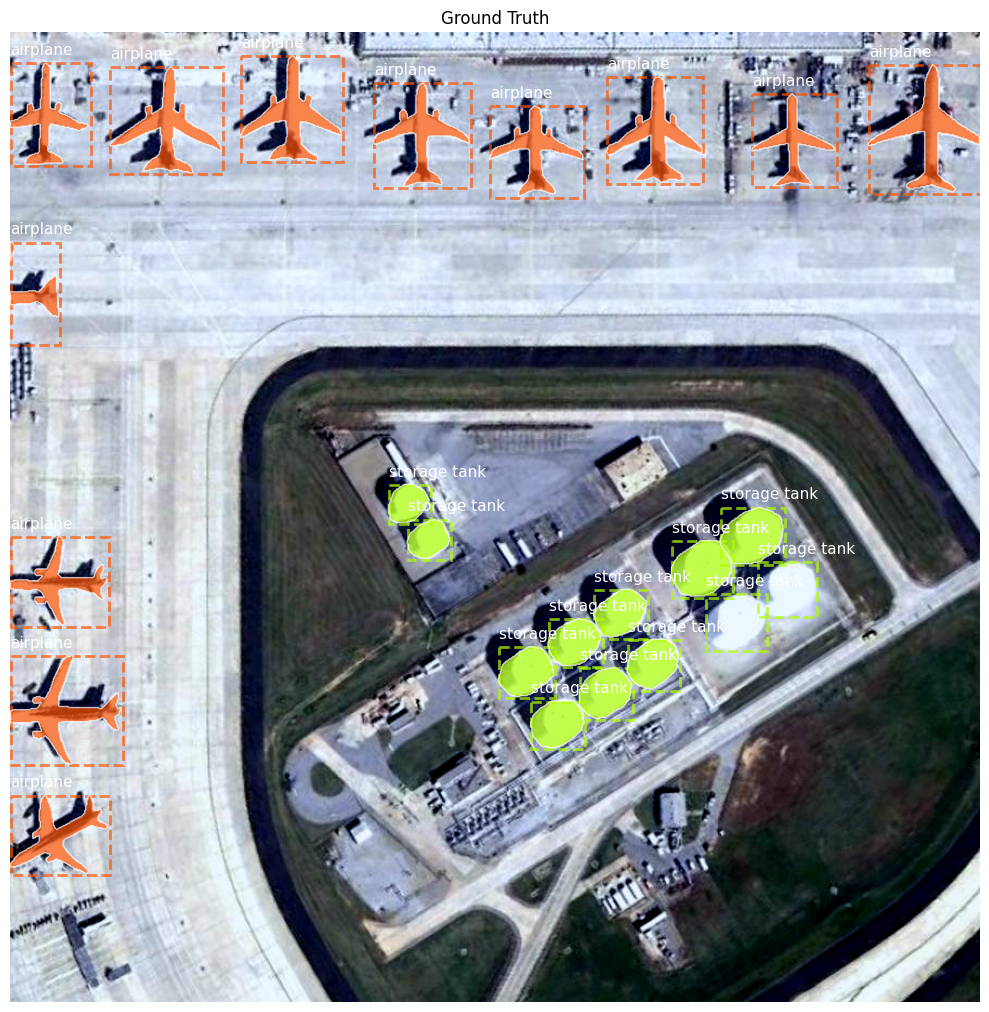

In [8]:
ds.plot(ds[20])
plt.show()
# plt.close()

In [9]:
def collate_fn(batch):
    new_batch = {
        "image": [item["image"] for item in batch],
        "boxes": [item["boxes"] for item in batch],
        "labels": [item["labels"] for item in batch],
        "masks": [item["masks"] for item in batch],
    }
    return new_batch

dl = DataLoader(ds, batch_size=4, num_workers=2, shuffle=True, collate_fn=collate_fn)

In [10]:
# The current (torchgeo 0.5.0) ObjectDetectionTask does not seem to support variable
# size inputs. We can quickly fix this by subclassing it and overriding the
# training_step method.
#from torchgeo.trainers import ObjectDetectionTask
from terratorch.tasks import ObjectDetectionTask

class VariableSizeInputObjectDetectionTask(ObjectDetectionTask):
    def training_step(self, batch, batch_idx, dataloader_idx=0):

        x = batch["image"]
        batch_size = len(x)  # we change this line to support variable size inputs
        y = [
            {"boxes": batch["boxes"][i], "labels": batch["labels"][i]}
            for i in range(batch_size)
        ]
        loss_dict = self(x, y)
        # pdb.set_trace()
        if isinstance(loss_dict, dict) == False:
            loss_dict = loss_dict.output
        train_loss: Tensor = sum(loss_dict.values())
        self.log_dict(loss_dict)
        return train_loss



In [11]:
# task = VariableSizeInputObjectDetectionTask(
#     model="faster-rcnn",
#     backbone="resnet18",
#     weights=True,
#     in_channels=3,
#     num_classes=11,
#     trainable_layers=3,
#     lr=1e-3,
#     patience=10,
#     freeze_backbone=False,
# )

In [12]:
with open('../confs/object_detection_vhr10_prithvi.yaml', 'r') as file:
    config = yaml.safe_load(file)

task = VariableSizeInputObjectDetectionTask(
    optimizer=config['optimizer']['class_path'].split('.')[-1],
    optimizer_hparams=config['optimizer']['init_args'],
    scheduler=config['lr_scheduler']['class_path'].split('.')[-1],
    scheduler_hparams=config['lr_scheduler']['init_args'],
    # patience=10,
    **config['model']['init_args']
)

In [13]:
# %debug

In [14]:
task.monitor = "loss_classifier"

In [15]:
trainer = pl.Trainer(
    default_root_dir="logs/",
    accelerator="cpu",
    # devices=[0],
    min_epochs=10,
    max_epochs=2,
    log_every_n_steps=20,
)

INFO: GPU available: False, used: False
INFO:lightning.pytorch.utilities.rank_zero:GPU available: False, used: False
INFO: TPU available: False, using: 0 TPU cores
INFO:lightning.pytorch.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO: HPU available: False, using: 0 HPUs
INFO:lightning.pytorch.utilities.rank_zero:HPU available: False, using: 0 HPUs


In [16]:
use_cuda = torch.cuda.is_available()
print(f"GPU available: {use_cuda}")

GPU available: False


In [ ]:
trainer.fit(task, train_dataloaders=dl)

/dccstor/cimf/paolo/miniconda3/envs/terratorch/lib/python3.10/site-packages/lightning/pytorch/trainer/configuration_validator.py:70: You defined a `validation_step` but have no `val_dataloader`. Skipping val loop.
INFO: 
  | Name          | Type                 | Params | Mode 
---------------------------------------------------------------
0 | model         | ObjectDetectionModel | 105 M  | train
1 | train_metrics | MetricCollection     | 0      | train
2 | val_metrics   | MetricCollection     | 0      | train
3 | test_metrics  | MetricCollection     | 0      | train
---------------------------------------------------------------
105 M     Trainable params
0         Non-trainable params
105 M     Total params
423.026   Total estimated model params size (MB)
321       Modules in train mode
0         Modules in eval mode
INFO:lightning.pytorch.callbacks.model_summary:
  | Name          | Type                 | Params | Mode 
--------------------------------------------------------------

Epoch 0:  23%|██████████████████████████████████████████████████▊                                                                                                                                                                             | 37/163 [26:11<1:29:12,  0.02it/s, v_num=81]

In [18]:
%debug

> /dccstor/cimf/paolo/miniconda3/envs/terratorch/lib/python3.10/site-packages/torchvision/ops/poolers.py(125)_setup_scales()
    123     # get the levels in the feature map by leveraging the fact that the network always
    124     # downsamples by a factor of 2 at each level.
--> 125     lvl_min = -torch.log2(torch.tensor(scales[0], dtype=torch.float32)).item()
    126     lvl_max = -torch.log2(torch.tensor(scales[-1], dtype=torch.float32)).item()
    127 



ipdb>  u


> /dccstor/cimf/paolo/miniconda3/envs/terratorch/lib/python3.10/site-packages/torchvision/ops/poolers.py(310)forward()
    308         x_filtered = _filter_input(x, self.featmap_names)
    309         if self.scales is None or self.map_levels is None:
--> 310             self.scales, self.map_levels = _setup_scales(
    311                 x_filtered, image_shapes, self.canonical_scale, self.canonical_level
    312             )



ipdb>  s


In [17]:
%debug

> /dccstor/cimf/paolo/miniconda3/envs/terratorch/lib/python3.10/site-packages/einops/einops.py(533)reduce()
    531             message += "\n Input is list. "
    532         message += "Additional info: {}.".format(axes_lengths)
--> 533         raise EinopsError(message + "\n {}".format(e))
    534 
    535 



ipdb>  u


> /dccstor/cimf/paolo/miniconda3/envs/terratorch/lib/python3.10/site-packages/einops/einops.py(591)rearrange()
    589 
    590     """
--> 591     return reduce(tensor, pattern, reduction="rearrange", **axes_lengths)
    592 
    593 

--KeyboardInterrupt--

KeyboardInterrupt: Interrupted by user


## Inference example

In [40]:
batch = next(iter(dl))
#batch["image"] = [image.to("cuda:0") for image in batch["image"]]

In [41]:
model = task.model
model.eval()

with torch.no_grad():
    out = model(batch["image"])

In [42]:
batch_idx = 0
sample = {
    "image": batch["image"][batch_idx],
    "boxes": batch["boxes"][batch_idx],
    "labels": batch["labels"][batch_idx],
    "masks": batch["masks"][batch_idx],
    "prediction_labels": out[batch_idx]["labels"],
    "prediction_boxes": out[batch_idx]["boxes"],
    "prediction_scores": out[batch_idx]["scores"],
}

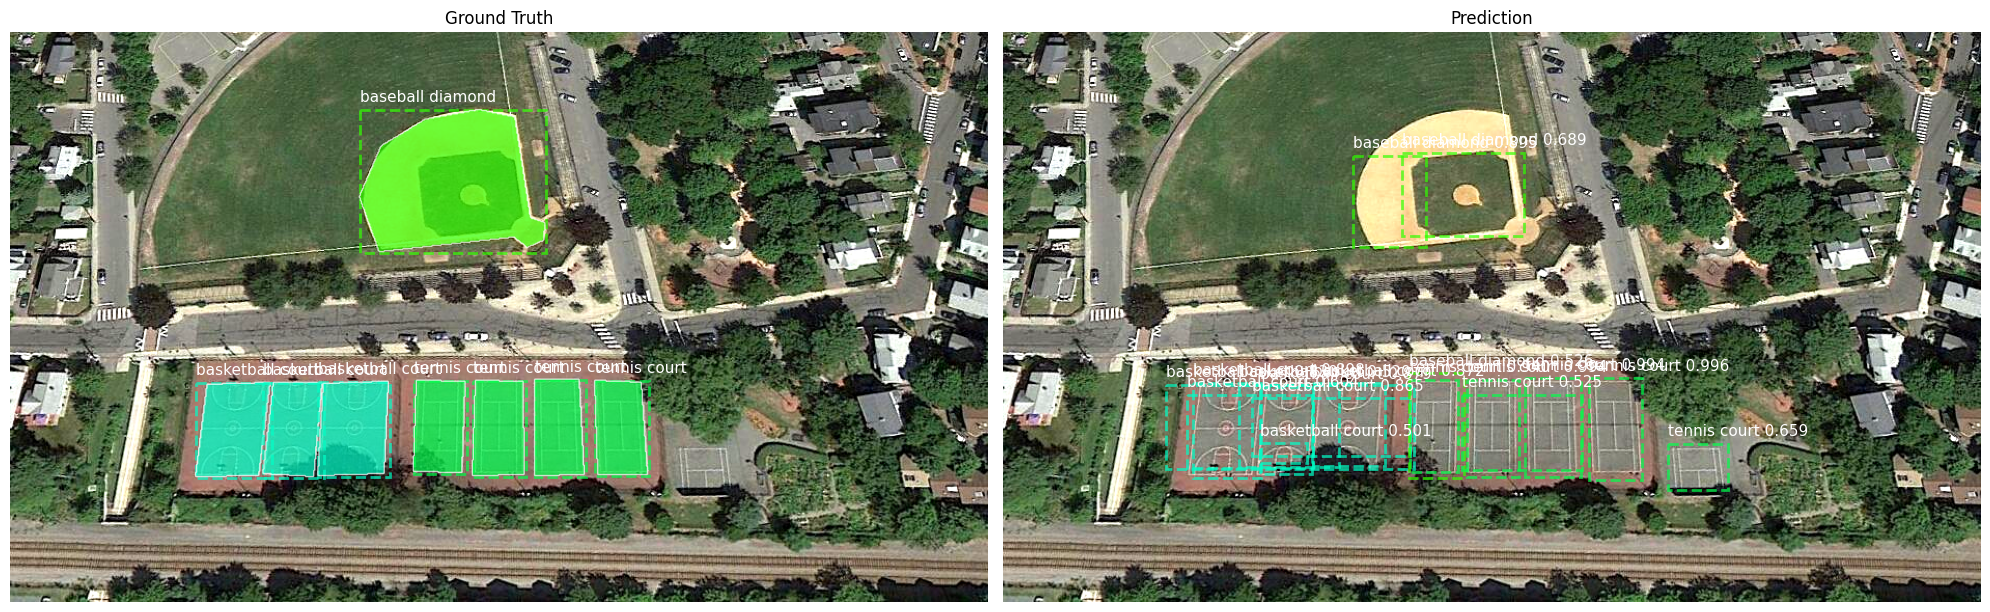

In [43]:
ds.plot(sample)
plt.show()
plt.close()